In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
os.chdir('F:\\Projects\\NLP_Readmission_Predictor\\data')

In [35]:
df_adm = pd.read_csv('ADMISSIONS.csv')

In [36]:
#Convert the data columns from strings to datetime. Errors = Coerce will account for missing dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [37]:
#Sort by subject ID and admission date to see the sequence of admittances
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [38]:
#Add the next admission date and type for each subject using groupby. If groupyby isn't used, then the dates will be from different subjects.
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
#Get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)


In [39]:
#Since we only want unplanned readmits, we need to replace the elective admissions with nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows, 'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows, 'NEXT_ADMISSION_TYPE'] = np.NaN

In [40]:
#Sort by subject ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
#Backfill(This will take awhile)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method='bfill')

In [41]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  df_adm.apply(lambda row: (row['NEXT_ADMITTIME']-row['DISCHTIME'])/np.timedelta64(1, 'D'),axis=1)


Text(0,0.5,'Counts')

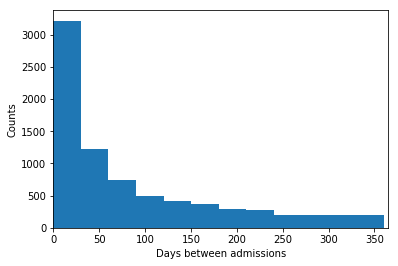

In [42]:
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')

In [43]:
df_notes = pd.read_csv('NOTEEVENTS.csv')

C:\Users\matth\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [47]:
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [48]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID', 'HADM_ID']).nth(-1)).reset_index()
                         
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple Discharge Summaries Per Admission'

In [49]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DAYS_NEXT_ADMIT', 'NEXT_ADMITTIME',
                          'ADMISSION_TYPE', 'DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID', 'HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID', 'HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased.'

In [50]:
df_adm_notes

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaN,NaT,NEWBORN,NaT,NaN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaN,NaT,NEWBORN,NaT,NaN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaN,NaT,EMERGENCY,2149-11-14 10:15:00,"Name: [**Known lastname 10050**], [**Known fi..."
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaN,NaT,NEWBORN,NaT,Admission Date: [**2103-6-28**] Dischar...
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2178-4-16**] ...


In [51]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [52]:
df_adm_notes['OUTPUT_LABEL'] = (df_adm_notes.DAYS_NEXT_ADMIT < 30).astype('int')

In [53]:
#shuffle the samples
df_adm_notes = df_adm_notes.sample(n = len(df_adm_notes), random_state=42)
df_adm_notes = df_adm_notes.reset_index(drop=True)
#Save 30% of the data as validation
df_valid_test = df_adm_notes.sample(frac=.30, random_state=42)
df_test = df_valid_test.sample(frac=.5,random_state=42)
df_valid = df_valid_test.drop(df_test.index)

#use the rest of the data as training data
df_train_all = df_adm_notes.drop(df_valid_test.index)

In [54]:
#split the training data into positive and negative
row_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[row_pos]
df_train_neg = df_train_all.loc[~row_pos]

In [55]:
#merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)], axis = 0)

#shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

In [56]:
def preprocess_text(df):
    #This function preprocesses the text by filling nan and replaces new lines('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT = df.TEXT.str.replace('\n',' ')
    df.TEXT = df.TEXT.str.replace('\r',' ')
    return df

In [57]:
#Preprocess the text
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [58]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [59]:
#Check that NLTK is installed
check = "This is a tokenized word 4342 1/12/5 blah blah blah."
word_tokenize(check)

['This',
 'is',
 'a',
 'tokenized',
 'word',
 '4342',
 '1/12/5',
 'blah',
 'blah',
 'blah',
 '.']

In [60]:
#This will strip the punctuation from the tokenized words, remove numbers and lowercase everything.
import string

def tokenize_better(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, ""))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [61]:
tokenize_better(check)

['this', 'is', 'a', 'tokenized', 'word', 'blah', 'blah', 'blah']

In [62]:
#import the vector to turn tokenized words to vectors
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenize_better)

vect.fit(['This is a test', "This test passes.", "Bring it on big.", ' The glass is nice and cool.'])

#matrix is stored as a sparse matrix(since you have alot of zeros)
X = vect.transform(['This is a test', "This test passes.", "Bring it on big.", ' The glass is nice and cool.'])

X.toarray()

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0]], dtype=int64)

In [63]:
#This will display the column names
vect.get_feature_names()

['a',
 'and',
 'big',
 'bring',
 'cool',
 'glass',
 'is',
 'it',
 'nice',
 'on',
 'passes',
 'test',
 'the',
 'this']

## ML Section

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=3000, tokenizer=tokenize_better)
#Fitting the vetorizer may take awhile
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_better at 0x0000019C6639C8C8>,
        vocabulary=None)

In [65]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

In [66]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

In [71]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [73]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [74]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 1 1 1 1 0 0 0 1]
[0.50456674 0.45395485 0.78098308 0.49454402 0.82611991 0.59482481
 0.45805644 0.77391847 0.23473838 0.49758118]


## Performance Metrics

In [75]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.744
Valid AUC:0.691
Train accuracy:0.684
Valid accuracy:0.677
Train recall:0.653
Valid recall:0.607
Train precision:0.695
Valid precision:0.102
Train specificity:0.714
Valid specificity:0.681
Train prevalence:0.500
Valid prevalence:0.056


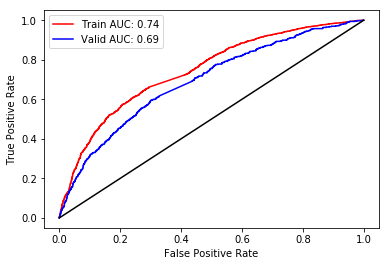

In [76]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

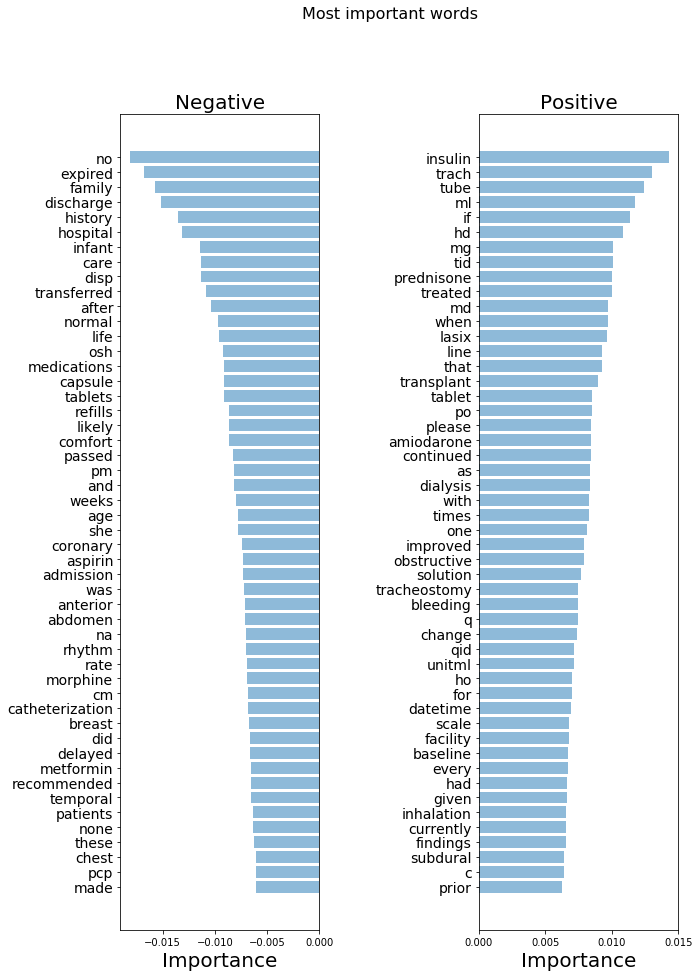

In [77]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

In [78]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

In [80]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenize_better,stop_words =my_new_stop_words)
#
# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

## Plot a learning curve

In [81]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

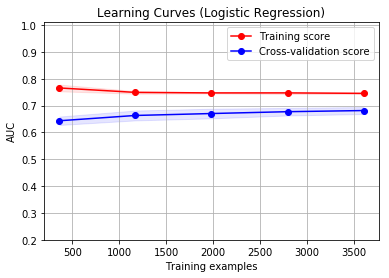

In [82]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
#Stopped on his cell 53